# read data 

In [1]:
# read data 
import pandas as pd
import numpy as np
df = pd.read_csv('version2.csv')
data = df[['narratives','label']]
data.head()

,narratives,label
0,There are many mistakes appear in my report wi...,"('Credit reporting, credit repair services, or..."
1,I was pulling my credit to looking into buying...,"('Credit reporting, credit repair services, or..."
2,"Since XXXX XXXX, I was working with a loan con...","('Mortgage', 'apply for mortgage')"
3,On XX/XX/XXXX I went to NTL in Delaware for a ...,"('loan', 'payment')"
4,"Hello CFPB, I am sending this complaint to you...","('Credit reporting, credit repair services, or..."


In [3]:
# print the number of documents
print('the number of documents:',len(data))

the number of documents: 87592


In [7]:
# print the number of unique categories
print('the original number of unique categories:', len(data.label.unique()))

the original number of unique categories: 42


In [5]:
# remove the categories that have small amount of cases 
data = data[data.label != "('Checking or savings account', 'others')"]
data = data[data.label != "('Mortgage', 'others')"]

In [9]:
print('unique categories for input data:', len(data.label.unique()))

unique categories for input data: 42


# tokenize and pad_sequences

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS=19000
MAX_DOC_LEN=1000
EMBEDDING_DIM = 300

# tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data["narratives"])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# sequence
sequences = tokenizer.texts_to_sequences(data["narratives"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_DOC_LEN, padding='post', truncating='post')

# print(padded_sequences[1])

/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 54927 unique tokens.


# label encoding

In [11]:
# one-hot 
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_label = encoder.fit_transform(data['label'])

In [12]:
# check the shape of labels
y_label.shape

(87531, 42)

# split train and test data 

In [13]:
# split the data set for train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences,y_label,test_size=0.2, random_state=1, stratify = y_label)

# load pre-trained word vector 

In [14]:
embeddings_index = {}

with open('glove.6B.300d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# define modeling function 

In [15]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

def textCNN(word_indexs, embeddings_indexs, pre_embeding = False, ini_trainable = False):
    
    max_doc_len=1000
    embedding_dim = 300

    # input layer
    main_input = Input(shape = (max_doc_len,), dtype = 'int32', name = 'main_input')

    # embeding layer
    if pre_embeding == True:
        
        max_nb_words=400000

        # embedding matrix for word in our dataset
        embedding_matrix = np.zeros((max_nb_words + 1, embedding_dim))
        for word, i in word_indexs.items():
            embedding_vector = embeddings_indexs.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
        # pre-trained word vector trainable?
        if ini_trainable == True:
            embedding_layer = Embedding( max_nb_words + 1, embedding_dim, weights=[embedding_matrix],\
                            input_length=max_doc_len, trainable= True, name = 'embedding')
        else:
            embedding_layer = Embedding( max_nb_words + 1, embedding_dim, weights=[embedding_matrix],\
                                input_length=max_doc_len, trainable=False, name = 'embedding')

    else:
        
        max_nb_words=19000
        
        embedding_layer = Embedding(input_dim = max_nb_words+1, output_dim=embedding_dim,\
                                    input_length=max_doc_len, name='embedding')


    embed_1 = embedding_layer(main_input)
    
    # filters for unigram
    conv1d_1= Conv1D(filters=64, kernel_size=1, name='conv_unigram', activation='relu')(embed_1)
    pool_1 = MaxPooling1D(max_doc_len-1+1, name='pool_unigram')(conv1d_1)
    flat_1 = Flatten(name='flat_unigram')(pool_1)

    # filters for bigram
    conv1d_2= Conv1D(filters=64, kernel_size=2, name='conv_bigram',activation='relu')(embed_1)
    pool_2 = MaxPooling1D(max_doc_len-2+1, name='pool_bigram')(conv1d_2)
    flat_2 = Flatten(name='flat_bigram')(pool_2)

    # filters for trigram
    conv1d_3= Conv1D(filters=64, kernel_size=3, name='conv_trigram',activation='relu')(embed_1)
    pool_3 = MaxPooling1D(max_doc_len-3+1, name='pool_trigram')(conv1d_3)
    flat_3 = Flatten(name='flat_trigram')(pool_3)

    # Concatenate flattened output
    z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

    # Create a dropout layer
    drop_1=Dropout(rate=0.5, name='dropout')(z)

    # Create a dense layer
    dense_1 = Dense(192, activation='relu', name='dense')(drop_1)

    # Create the output layer
    preds = Dense(42, activation='softmax', name='output')(dense_1)

    # create the model with input layer and the output layer
    model = Model(inputs=main_input, outputs=preds)
    
    model.summary()
    
    return model

# define trainning function

In [16]:
import datetime

def train_model(input_model, train_set, train_label, test_set, test_label, weight_name ):
    
    # the file path to save best model
    BEST_MODEL_FILEPATH= weight_name
    
    # define early stopping based on validation loss
    earlyStopping=EarlyStopping(monitor='val_loss', patience= 1, verbose= 0, mode='min')

    # define checkpoint to save best model
    checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    
    # complie model 
    input_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    
    BATCH_SIZE = 600
    NUM_EPOCHES = 30
    
    training=input_model.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES,\
                             callbacks=[earlyStopping, checkpoint],validation_data=[test_set, test_label], verbose=1)
    
    return training 

#  define evaluation function 

In [20]:
def eva_model(input_model, input_weight, encoders,test_label ):
    
    input_model.load_weights('./model/{}'.format(input_weight))
    
    pred = input_model.predict(X_test)
#     print(pred[0:5])
    
    
#     scores = input_model.evaluate(X_test, y_test, verbose=1)
#     print("%s: %.2f%%" % (input_model.metrics_names[1], scores[1]*100))
    
    from sklearn.metrics import classification_report
    pred = np.where (pred>0.6, 1, 0)
    Result = classification_report(test_label, pred, target_names = encoders.classes_)
    print(Result)

# 1. no pre-trained word vector

In [18]:
CNNmodel = textCNN(word_index,embeddings_index, pre_embeding = False)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1000, 300)     5700300     main_input[0][0]                 
____________________________________________________________________________________________________
conv_unigram (Conv1D)            (None, 1000, 64)      19264       embedding[0][0]                  
____________________________________________________________________________________________________
conv_bigram (Conv1D)             (No

In [ ]:
train_model(CNNmodel,X_train, y_train,X_test, y_test,'best_model_no_pre')

#### since the training processing takes too long, the log file is attached 
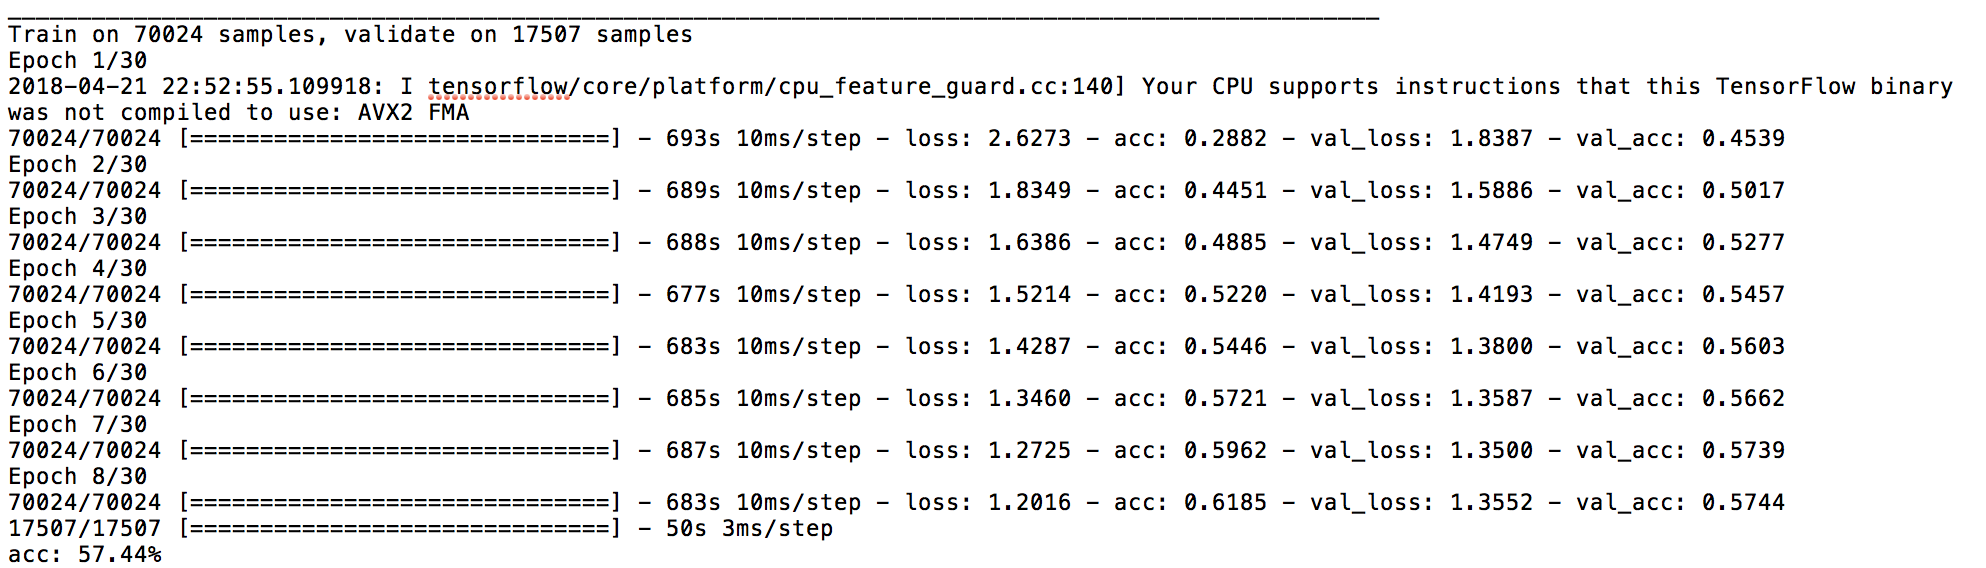

In [21]:
eva_model(CNNmodel, "best_model_no_pre", encoder, y_test)

                                                                                                                                                                      precision    recall  f1-score   support

                                                                                                               ('Checking or savings account', 'Closing an account')       0.77      0.08      0.14       132
                                                                                                              ('Checking or savings account', 'Managing an account')       0.69      0.31      0.43       565
                                                                                                               ('Checking or savings account', 'Opening an account')       0.65      0.30      0.41       121
                                                                                           ('Checking or savings account', 'Problem caused by your funds being low')       0.53

/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 2. pre-trained word vector, not trainable

In [22]:
pre_CNNmodel = textCNN(word_index,embeddings_index, pre_embeding = True, ini_trainable = False )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1000, 300)     120000300   main_input[0][0]                 
____________________________________________________________________________________________________
conv_unigram (Conv1D)            (None, 1000, 64)      19264       embedding[0][0]                  
____________________________________________________________________________________________________
conv_bigram (Conv1D)             (None, 999, 64)       38464       embedding[0][0]                  
___________________________________________________________________________________________

In [ ]:
train_model(pre_CNNmodel,X_train, y_train,X_test, y_test, 'best_model_pre')

#### since the training processing takes too long, the log file is attached 
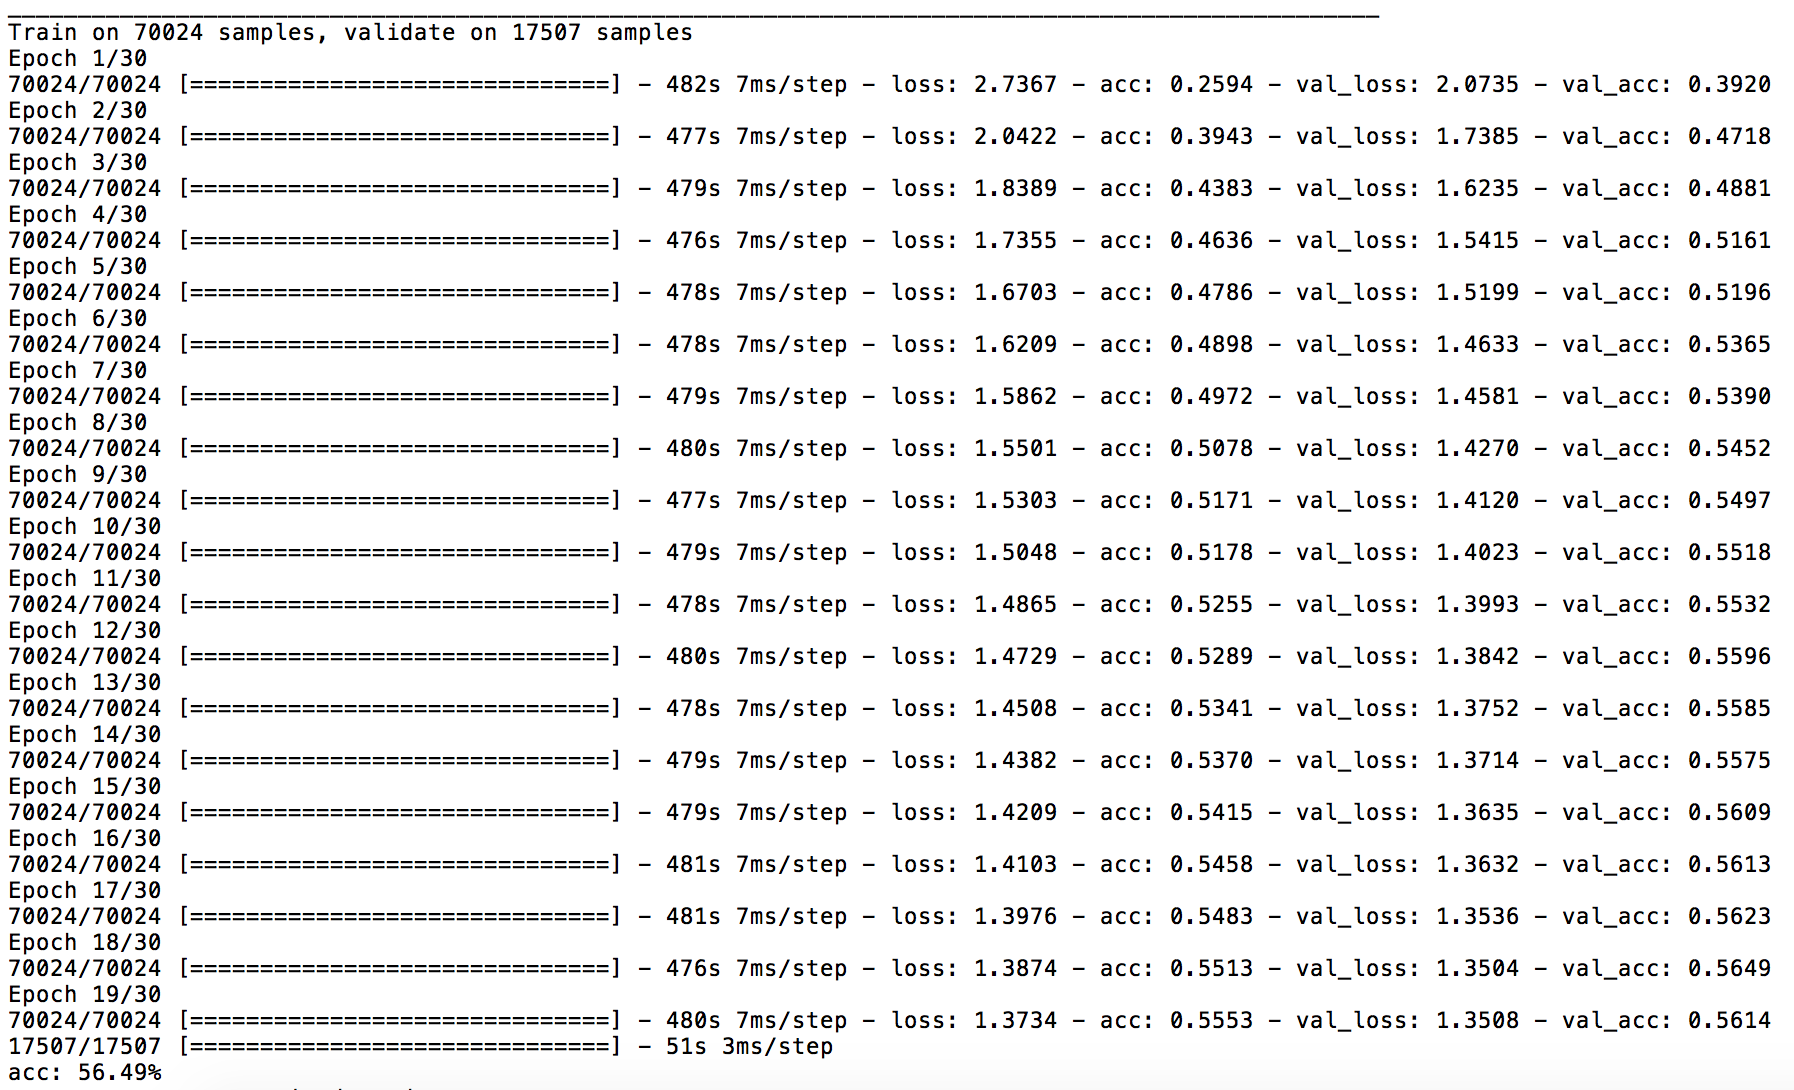

In [23]:
eva_model(pre_CNNmodel, "best_model_pre", encoder, y_test)

                                                                                                                                                                      precision    recall  f1-score   support

                                                                                                               ('Checking or savings account', 'Closing an account')       0.85      0.21      0.34       132
                                                                                                              ('Checking or savings account', 'Managing an account')       0.76      0.15      0.26       565
                                                                                                               ('Checking or savings account', 'Opening an account')       0.67      0.26      0.37       121
                                                                                           ('Checking or savings account', 'Problem caused by your funds being low')       0.72

/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 3. pre-trained word vector, trainable

In [24]:
pre_CNNmodel_train = textCNN(word_index,embeddings_index, pre_embeding = True, ini_trainable = True )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1000, 300)     120000300   main_input[0][0]                 
____________________________________________________________________________________________________
conv_unigram (Conv1D)            (None, 1000, 64)      19264       embedding[0][0]                  
____________________________________________________________________________________________________
conv_bigram (Conv1D)             (None, 999, 64)       38464       embedding[0][0]                  
___________________________________________________________________________________________

In [ ]:
train_model(pre_CNNmodel_train,X_train, y_train,X_test, y_test, 'best_model_pre_train')

#### since the training processing takes too long, the log file is attached 
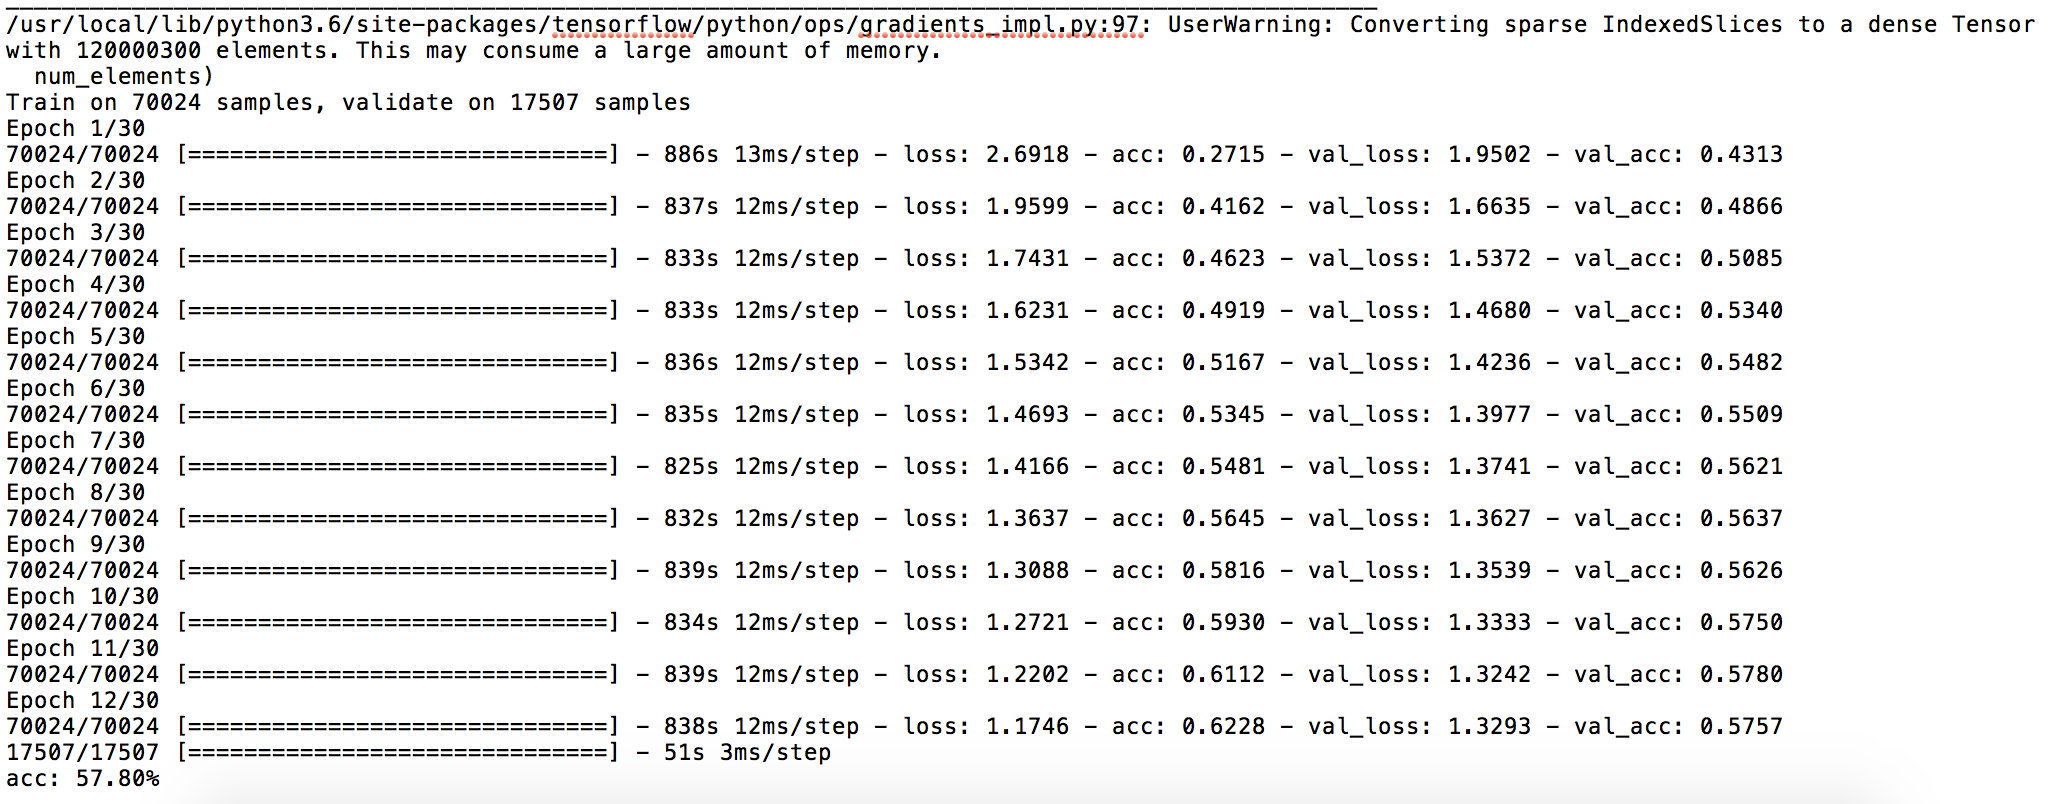

In [25]:
eva_model(pre_CNNmodel_train, 'best_model_pre_train', encoder, y_test)

                                                                                                                                                                      precision    recall  f1-score   support

                                                                                                               ('Checking or savings account', 'Closing an account')       1.00      0.04      0.07       132
                                                                                                              ('Checking or savings account', 'Managing an account')       0.74      0.28      0.40       565
                                                                                                               ('Checking or savings account', 'Opening an account')       0.71      0.33      0.45       121
                                                                                           ('Checking or savings account', 'Problem caused by your funds being low')       0.53

/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
